In [1]:
import matplotlib.pyplot as plt
import thejoker.units as xu
import astropy.units as u
import statistics as stat
import seaborn as sns
import thejoker as tj
import pandas as pd
import numpy as np
import arviz as az
import pymc as pm
import corner
import math 
import h5py
import os

from astropy.visualization.units import quantity_support
from thejoker import JokerPrior, TheJoker, RVData
from sklearn.metrics import mean_squared_error
from thejoker.plot import plot_rv_curves
from scipy.stats import gaussian_kde
from astropy.time import Time
from os.path import join
from scipy import stats

In [2]:
# Configurar el estilo de fuente global a 'serif'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif', 'Bitstream Vera Serif', 'Computer Modern Roman', 'New Century Schoolbook', 'Century Schoolbook L', 'Utopia', 'ITC Bookman', 'Bookman', 'Nimbus Roman No9 L', 'Palatino', 'Charter', 'serif']

In [3]:
# Lee el archivo de texto y crea un DataFrame
nombres_columnas = ['Estrella', 'TYC', '2MASS']
data = pd.read_csv('Nombres_de_Estrellas.txt', delimiter=' ', names=nombres_columnas, header=None)  # Si el archivo está tabulado, usa '\t' como separador
data

,Estrella,TYC,2MASS
0,Krich_1,TYC22-591-1,2MASSJ01030596+0434459
1,Krich_2,TYC26-777-1,2MASSJ01194936+0634115
2,Na_rich,TYC6908-1643-1,2MASSJ20320320-2332524
3,Nrich_1,TYC4686-2039-1,2MASSJ01575297-0316508
4,Nrich_2,TYC8517-1671-1,2MASSJ05120630-5913438
5,Nrich_3,TYC244-273-1,2MASSJ10022398+0216045
6,Nrich_4,TYC250-1352-1,2MASSJ10071742+0605101
7,Nrich_5,TYC269-474-1,2MASSJ11173689+0645217
8,Nrich_6,TYC7408-694-1,2MASSJ18461977-3021506
9,Nrich_7,TYC5256-183-1,2MASSJ23513172-0312308


In [4]:
columns = ["Star","Date","RV","err_RV","S/N"]
Estrella = {}
mean = []
range = []
std = []
for i in data["Estrella"]:
    Estrella[i] = pd.read_csv(i+'.dat', delimiter='\t', names=columns, header=None)
    #print(Estrella[i])
    mean.append(np.mean(Estrella[i]["RV"]))
    range.append(np.max(Estrella[i]["RV"])-np.min(Estrella[i]["RV"]))
    std.append(np.std(Estrella[i]["RV"]))

In [5]:
Estrella["Si_rich"]

,Star,Date,RV,err_RV,S/N
0,TYC5805-233-1,2.459826e+06,-166.8729,0.0610,32
1,TYC5805-233-1,2.459826e+06,-166.8701,0.0598,29
2,TYC5805-233-1,2.459826e+06,-166.9451,0.0434,31
3,TYC5805-233-1,2.459826e+06,-166.6526,0.0240,36
4,TYC5805-233-1,2.459827e+06,-166.6802,0.0275,37
5,TYC5805-233-1,2.459827e+06,-166.6016,0.0176,48
6,TYC5805-233-1,2.459830e+06,-166.5698,0.0301,29
7,TYC5805-233-1,2.459837e+06,-166.5935,0.0387,24
8,TYC5805-233-1,2.459853e+06,-166.3089,0.0208,39
9,TYC5805-233-1,2.459854e+06,-166.3548,0.0231,41


In [6]:
# Obtén la ruta absoluta
file_path = os.path.abspath('news_RV/Sirich_2M22045404-1148287.csv')
print(file_path)

# Luego intenta leer el archivo
df = pd.read_csv(file_path)
df_ordenado = df.sort_values(by='JD')
df_ordenado = df_ordenado[df_ordenado['STARFLAG']==0].reset_index(drop=True)
df_ordenado

/home/alexandert/Docs_Jupyter/9.Joven_Investigador/Nrich/news_RV/Sirich_2M22045404-1148287.csv


,APOGEE_ID,TARGET_ID,MJD,SNR,STARFLAG,STARFLAGS,DATEOBS,JD,VRELERR,VHELIO
0,2M22045404-1148287,2M22045404-1148287,58052,202334.0,0,NaN,2017-10-25T23:55:35.945,2.458053e+06,0.036627,-172.238581


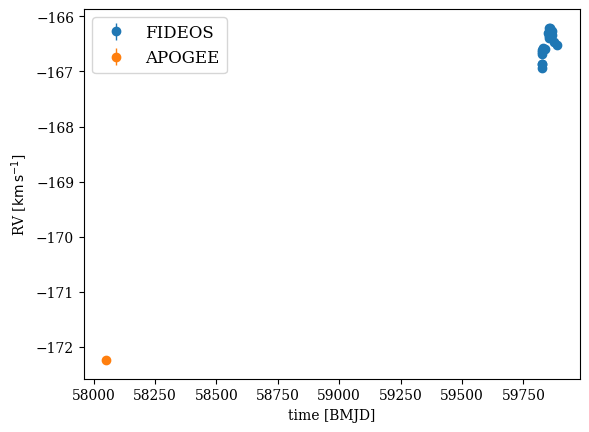

In [7]:
fideos_data = tj.RVData(
    t=np.array(Estrella["Si_rich"]["Date"])-2400000.5,
    rv=np.array(Estrella["Si_rich"]["RV"]) * u.km/u.s,
    rv_err=np.array(Estrella["Si_rich"]["err_RV"]) * u.km/u.s,
)

apogee_data = tj.RVData(
    t=np.array(df_ordenado["JD"])-2400000.5,
    rv=np.array(df_ordenado["VHELIO"])* u.km/u.s,
    rv_err=np.array(df_ordenado["VRELERR"])* u.km/u.s,
)

data = [apogee_data, fideos_data]
for d, name in zip([fideos_data, apogee_data], ["FIDEOS", "APOGEE"]):
    d.plot(color=None, label=name)
plt.legend(fontsize=12)

In [8]:
t = np.concatenate((np.array(df_ordenado["JD"]),np.array(Estrella["Si_rich"]["Date"])))-2400000.5 #Convirtiendo de JD a MBJD
rv = np.concatenate((np.array(df_ordenado["VHELIO"]),np.array(Estrella["Si_rich"]["RV"]))) * u.km/u.s
err = np.concatenate((np.array(df_ordenado["VRELERR"]),np.array(Estrella["Si_rich"]["err_RV"]))) * u.km/u.s
data = tj.RVData(t=t, rv=rv, rv_err=err)


### The Joker | Con wave

Estos datos fueron calculados teniendo en cuenta los siguientes parámetros.

$$P_{min} = 2 ~días$$
$$P_{max} = e^8 ~días$$
$$sigma\_K0=30 * u.km / u.s$$
$$sigma\_v=100 * u.km / u.s$$

Además el número de priors que se logró establecer es $J=2^{25}$

In [9]:
samples = tj.JokerSamples.read("TJ_samples_Sirich.hdf5")
samples

<JokerSamples [P, e, omega, M0, s, K, v0] (431 samples)>

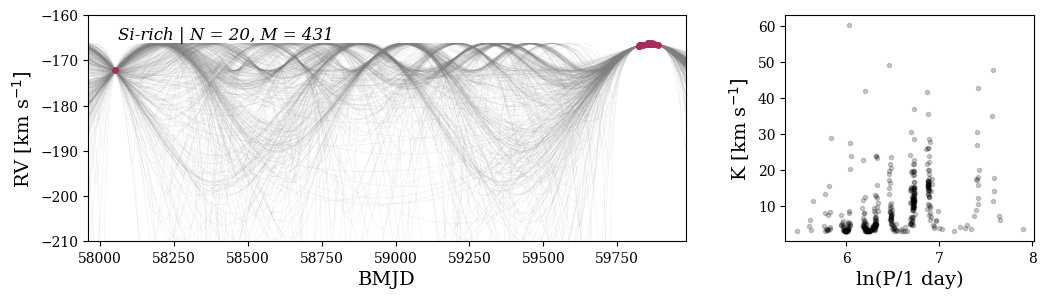

In [10]:
fig = plt.figure(figsize=(22,10))

gs = fig.add_gridspec(nrows=3, ncols=3, left=0.05, right=0.48, wspace=0.4)
f_ax1 = fig.add_subplot(gs[-1, :-1])
f_ax2 = fig.add_subplot(gs[-1,-1])

_ = tj.plot_rv_curves(samples[:500],data=data,plot_kwargs=dict(color="tab:grey",alpha = 0.1),data_plot_kwargs=dict(color="#A52C60"),relative_to_t_ref=False,ax=f_ax1)
f_ax2.scatter(np.log(samples[:500]['P'].value), samples[:500]['K'].value,marker='.', color='k', alpha=0.2)

f_ax1.set_xlabel("BMJD",fontsize=14)
f_ax1.set_ylabel("RV [km s$^{-1}]$", fontsize=14)

f_ax2.set_xlabel("ln(P/1 day)",fontsize=14)
f_ax2.set_ylabel("K [km s$^{-1}]$ ",fontsize=14)

f_ax1.set_ylim(-210,-160)
f_ax1.text(0.05, 0.95, f'Si-rich | N = {len(t)}, M = {len(samples[:500])}', transform=f_ax1.transAxes, fontsize = 12, verticalalignment='top', horizontalalignment='left', fontstyle = 'italic')
plt.show()

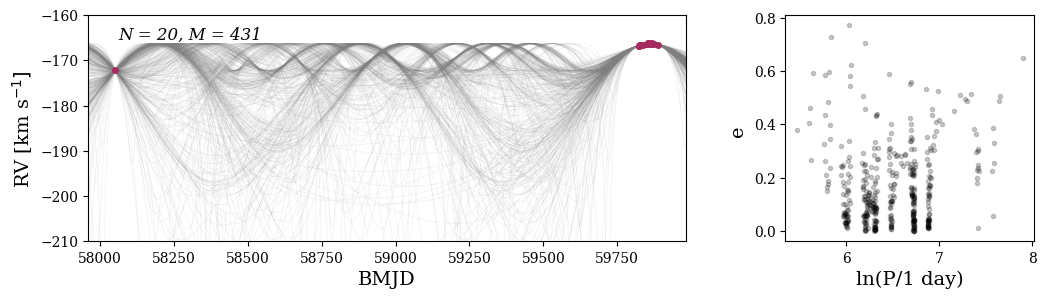

In [11]:
fig = plt.figure(figsize=(22,10))

gs = fig.add_gridspec(nrows=3, ncols=3, left=0.05, right=0.48, wspace=0.4)
f_ax1 = fig.add_subplot(gs[-1, :-1])
f_ax2 = fig.add_subplot(gs[-1,-1])

_ = tj.plot_rv_curves(samples[:500],data=data,plot_kwargs=dict(color="tab:grey", alpha = 0.1),data_plot_kwargs=dict(color="#A52C60"),relative_to_t_ref=False,ax=f_ax1)
f_ax2.scatter(np.log(samples[:500]['P'].value), samples[:500]['e'].value,marker='.', color='k', alpha=0.2)

f_ax1.set_xlabel("BMJD",fontsize=14)
f_ax1.set_ylabel("RV [km s$^{-1}]$", fontsize=14)

f_ax2.set_xlabel("ln(P/1 day)",fontsize=14)
f_ax2.set_ylabel("e ",fontsize=14)

f_ax1.set_ylim(-210,-160)
f_ax1.text(0.05, 0.95, f'N = {len(t)}, M = {len(samples[:500])}', transform=f_ax1.transAxes, fontsize = 12, verticalalignment='top', horizontalalignment='left', fontstyle = 'italic')
plt.show()

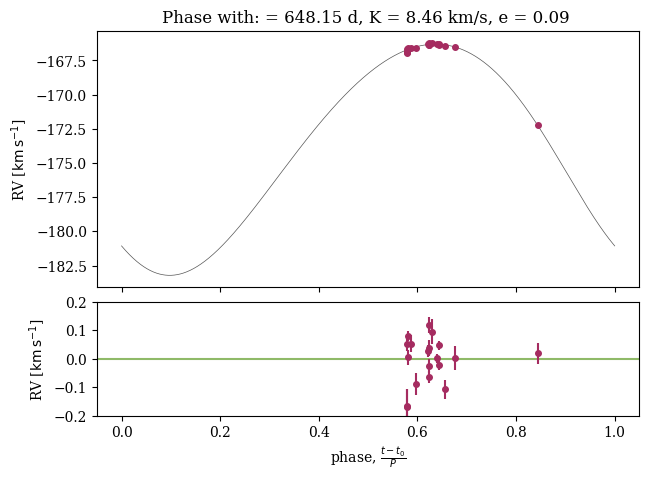

In [12]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(7, 5), gridspec_kw={"height_ratios": (1.8, 0.8), 'hspace': 0.08})

ax[0].set_title(f"Phase with: = {round(float(samples.median_period()['P'].value),2)} d, K = {round(float(samples.median_period()['K'].value),2)} km/s, e = {round(float(samples.median_period()['e'].value),2)} ")

    
_ = tj.plot_phase_fold(samples.median_period(),data=data,ax=ax[0],remove_trend = False,data_plot_kwargs=dict(color="#A52C60"))
_ = tj.plot_phase_fold(samples.median_period(), data, ax=ax[1], residual=True,data_plot_kwargs=dict(color="#A52C60"))

ax[1].axhline(0, zorder=-10, color="#73a942", alpha=0.8)
ax[1].set_ylim(-0.2, 0.2)

for ax in fig.get_axes():
    ax.label_outer()
    #ax.grid(linestyle='-', linewidth=0.1)

(2.0, 10.0)

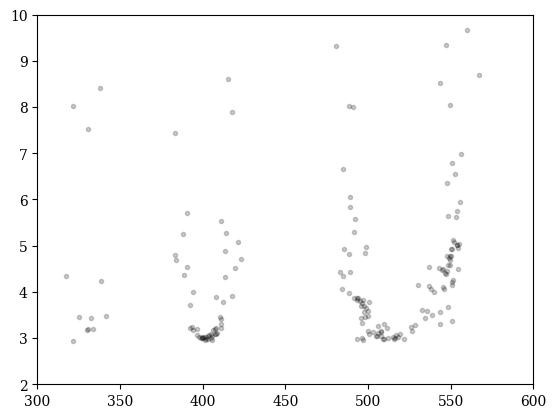

In [13]:
plt.scatter(samples[:500]['P'].value, samples[:500]['K'].value,marker='.', color='k', alpha=0.2)
plt.xlim(300,600)
plt.ylim(2,10)

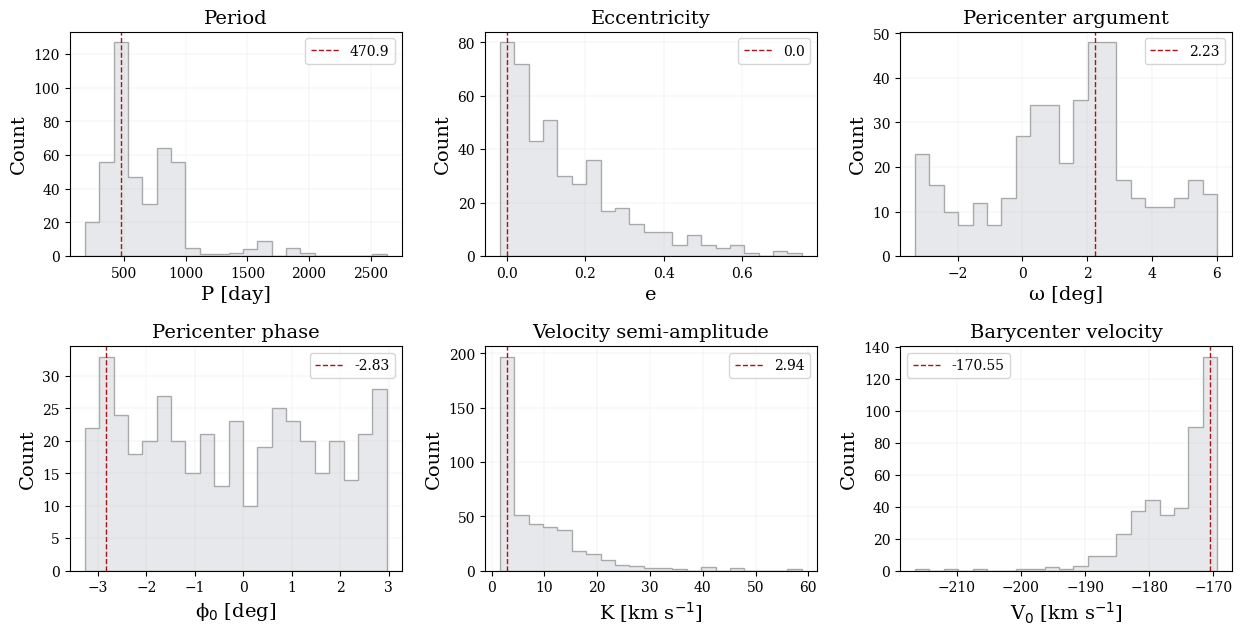

In [14]:
variables = ["P", "e", "omega", "M0", "K", "v0"]
xlabel = ["P [day]", "e", "ω [deg]", "ϕ$_0$ [deg]", "K [km s$^{-1}$]","V$_0$ [km s$^{-1}$]"]
title = ["Period","Eccentricity", "Pericenter argument", "Pericenter phase", "Velocity semi-amplitude", "Barycenter velocity"]
picos = []

fig = plt.figure(figsize=(15,7))

gs = fig.add_gridspec(2, 3, hspace=0.4, wspace=0.25)
(ax1,ax2,ax3), (ax4,ax5,ax6) = gs.subplots(sharey = False, sharex = False)

for ax,i in zip(fig.get_axes(),np.arange(len(variables))):
    ax.set_ylabel("Count", fontsize = 14)
    ax.set_xlabel(xlabel[i], fontsize = 14)
    ax.set_title(title[i], fontsize = 14)
    conteos, bins, _  =  ax.hist(samples[variables[i]], bins = "sqrt", histtype='stepfilled', density = False ,alpha=0.3, align = 'left', color = '#adb5bd', ec="k")
    indice_maximo = np.argmax(conteos)
    
    # Obtener el valor del pico más alto
    pico_mas_alto = bins[indice_maximo]
    picos.append(pico_mas_alto)
    # Agregar una línea vertical en el pico más alto
    ax.axvline(x=pico_mas_alto, color='#a4161a', linestyle='--', linewidth = 1, label = f"{round(pico_mas_alto,2)}")
    ax.grid(linestyle='-', linewidth=0.1)
    ax.legend()

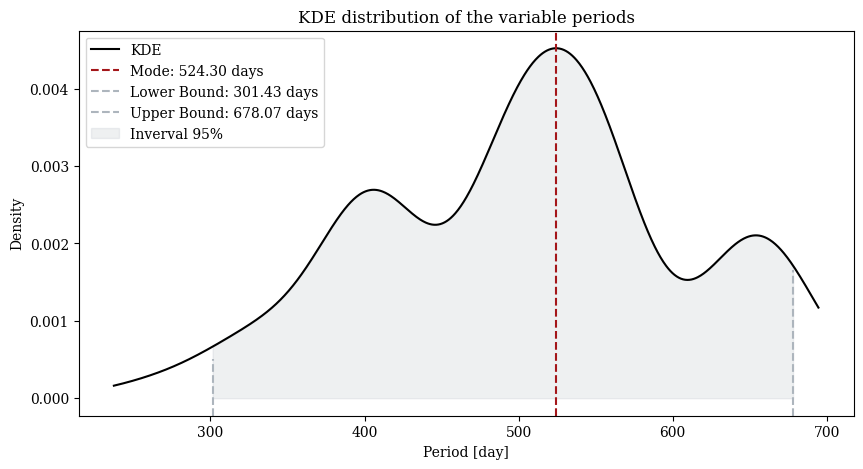

In [15]:
Periodos = samples[(samples["P"].value>=0) & (samples["P"].value<=700)]

kde = gaussian_kde(Periodos["P"].value, bw_method='scott')  # bw_method puede ajustarse si es necesario
x_grid = np.linspace(min(Periodos["P"].value), max(Periodos["P"].value), 1000)
kde_values = kde(x_grid)
moda = x_grid[np.argmax(kde_values)]

#moda = picos[0]
cumulative_probs = np.cumsum(kde_values)
cumulative_probs /= cumulative_probs[-1]  # Normalizar para que el máximo sea 1

# Buscar los índices correspondientes al 2.5% y 97.5% alrededor de la moda
lower_bound = x_grid[np.argmax(cumulative_probs > 0.025)]
upper_bound = x_grid[np.argmax(cumulative_probs > 0.975)]

plt.figure(figsize=(10,5))
plt.plot(x_grid, kde_values, label='KDE', color = "k")
plt.axvline(moda, color='#a4161a', linestyle='--', label=f'Mode: {moda:.2f} days')
plt.axvline(lower_bound, color='#adb5bd', linestyle='--', ymin = 0, ymax=kde(lower_bound)[0]/kde_values.max(), label=f'Lower Bound: {lower_bound:.2f} days')
plt.axvline(upper_bound, color='#adb5bd', linestyle='--', ymin = 0, ymax=kde(upper_bound)[0]/kde_values.max(), label=f'Upper Bound: {upper_bound:.2f} days')
plt.fill_between(x_grid, 0, kde_values, where=(x_grid >= lower_bound) & (x_grid <= upper_bound), color='#adb5bd', alpha=0.2, label='Inverval 95%')
plt.legend()
plt.xlabel('Period [day]')
plt.ylabel('Density')
plt.title('KDE distribution of the variable periods')
plt.show()

In [16]:
indice = np.abs(Periodos["P"].value - moda).argmin()
valor = Periodos["P"][indice]
orbita = samples[samples["P"] == valor]
orbita

<JokerSamples [P, e, omega, M0, s, K, v0] (1 samples)>

In [17]:
picos

[470.9018650627295,
 0.0005484399148758184,
 2.23496804759901,
 -2.829407530470145,
 2.944372044497986,
 -170.54913501903198]

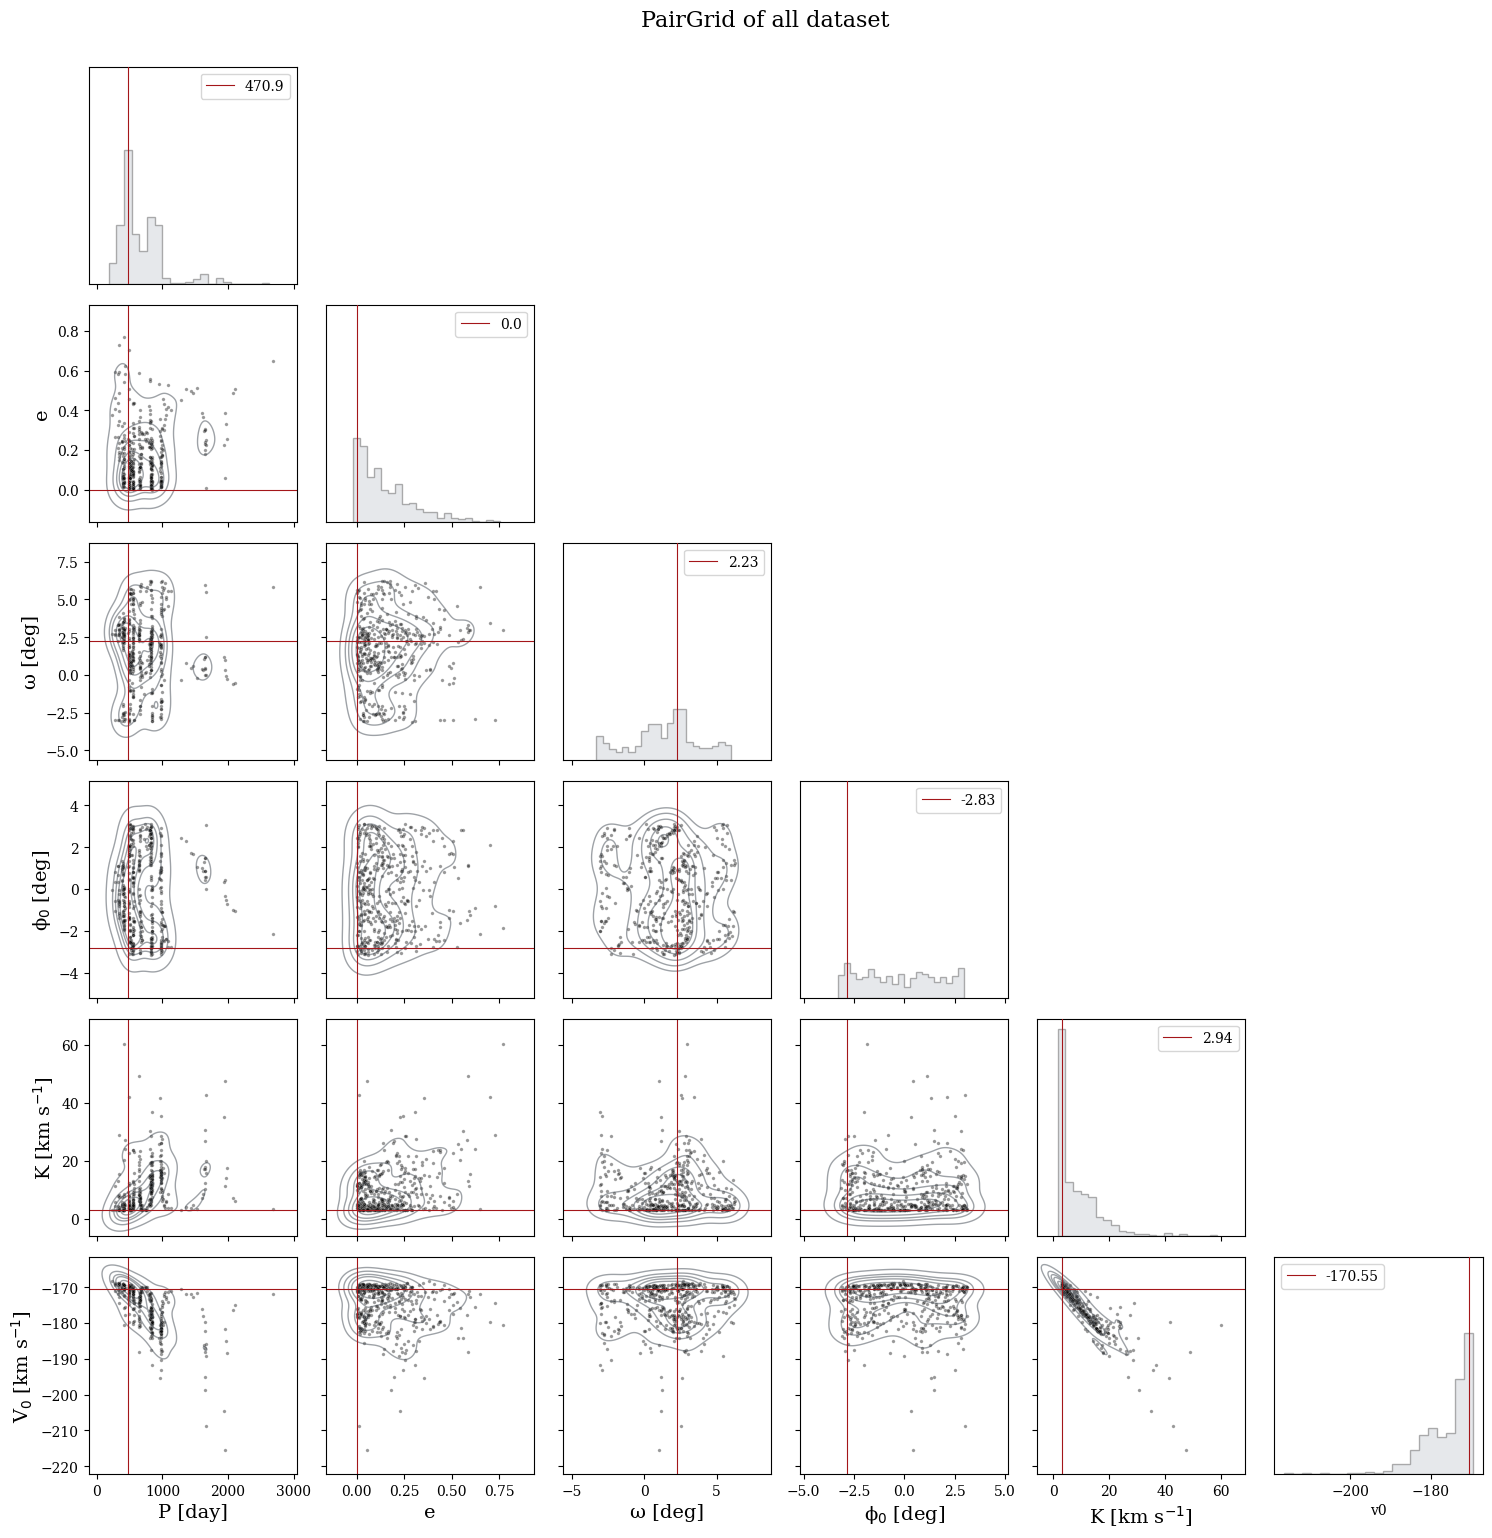

In [18]:
# Crear un gráfico de correlación utilizando pairplot
df = samples.tbl.to_pandas()
g = sns.PairGrid(df, 
            x_vars=["P", "e", "omega", "M0", "K", "v0"],
            y_vars=["P", "e", "omega", "M0", "K", "v0"],
            corner=True)                                   # No muestra las de encima de la diagonal
# Mostrar el gráfico

g.map_diag(plt.hist,  bins = "sqrt", histtype='stepfilled', density = False ,alpha=0.3, align = 'left', color = '#adb5bd', ec="k")             #Histogramas en la diagonal
g.map_lower(sns.kdeplot,linewidths = 1, levels=6,  color="#3F4750",thresh=.1, alpha = 0.5)             # Muestra los contornos
g.map_lower(sns.scatterplot,s = 6, alpha = 0.4, color="k")                     # Muestra los puntos

# Añadir bordes y rejillas a cada cuadrícula
for ax in g.axes.flatten():
    if ax is not None:
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['top'].set_visible(True)
        ax.grid(False)

# Agregar líneas verticales y horizontales en los gráficos de densidad fuera de la diagonal
for i, x_var in enumerate(variables):
    for j, y_var in enumerate(variables):
        if i != j:
            ax = g.axes[j, i]
            if ax is not None:
                ax.axvline(x=picos[i], color='#a4161a', linestyle='-', linewidth=0.8)
                ax.axhline(y=picos[j], color='#a4161a', linestyle='-', linewidth=0.8)
                ax.set_xlabel(xlabel[i], fontsize = 14)
                ax.set_ylabel(xlabel[j], fontsize = 14)

# Agregar líneas verticales personalizadas en las diagonales

for i in np.arange(len(g.diag_axes)):
    ax = g.diag_axes[i]
    ax.axvline(x=picos[i], color='#a4161a', linestyle='-', linewidth = 0.8, label = f"{round(picos[i],2)}")
    ax.legend()
    
ax.set_ylabel(xlabel[-1], fontsize = 14)

# Título del PairGrid
g.fig.suptitle("PairGrid of all dataset", y=1.02, fontsize = 16)
plt.show()

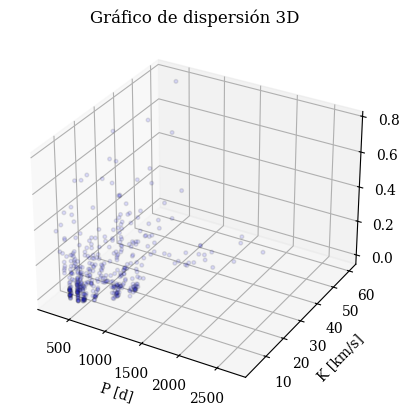

In [19]:
# Datos de muestra
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')

ax.set_xlabel("P [d]")
ax.set_ylabel("K [km/s]")
ax.set_zlabel("e")
# ax.set_ylim(0,30)
plt.title("Gráfico de dispersión 3D")

# Gráfico de dispersión 3D
ax.scatter(samples["P"], samples["K"], samples["e"],marker="o", s=7, color = "b", alpha=0.12, ec='#212325')

plt.show()

In [20]:
len(bins)

22

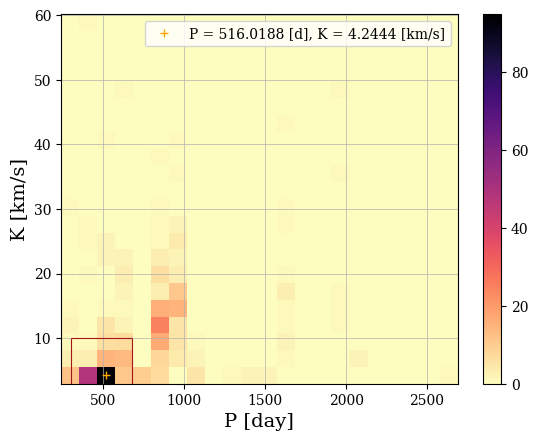

Coordenadas del valor más significativo:
x = 516.0187535108191
y = 4.244406710184082


In [21]:
bin = 22

hist, x_edges, y_edges = np.histogram2d(x=samples['P'].value, y=samples['K'].to(u.km/u.s).value, bins=bin)

# Encuentra las coordenadas del bin con el valor máximo en el histograma
max_index = np.unravel_index(np.argmax(hist), hist.shape)
x_max_density = (x_edges[max_index[0]] + x_edges[max_index[0] + 1]) / 2
y_max_density = (y_edges[max_index[1]] + y_edges[max_index[1] + 1]) / 2

# Grafica el histograma
fig, ax = plt.subplots()
h = ax.hist2d(x=samples['P'].value, y=samples['K'].to(u.km/u.s).value, bins=bin, cmap = "magma_r")
fig.colorbar(h[3], ax=ax)
ax.plot(x_max_density, y_max_density, "+", color="orange", label=f"P = {round(x_max_density, 4)} [d], K = {round(y_max_density, 4)} [km/s]")
ax.set_xlabel("P [day]", fontsize = 14)
ax.set_ylabel("K [km/s]", fontsize = 14)

xmin = lower_bound
xmax = upper_bound
ymin = 0
ymax = 10

ax.vlines(x=xmin, ymin = ymin, ymax = ymax, color='#a4161a', linestyle='-', linewidth=0.8)
ax.vlines(x=xmax, ymin = ymin, ymax = ymax, color='#a4161a', linestyle='-', linewidth=0.8)

ax.hlines(y=ymin ,xmin = xmin, xmax = xmax, color='#a4161a', linestyle='-', linewidth=0.8)
ax.hlines(y=ymax, xmin = xmin, xmax = xmax, color='#a4161a', linestyle='-', linewidth=0.8)

plt.grid(linestyle='-', linewidth=0.5)
plt.legend()
plt.show()

print("Coordenadas del valor más significativo:")
print("x =", x_max_density)
print("y =", y_max_density)

In [22]:
mask_P = (samples["P"].value>=xmin) & (samples["P"].value<=xmax)

Filtrado = samples[mask_P]
mask_K = (Filtrado["K"].value>=ymin) & (Filtrado["K"].value<=ymax)

Filtrado = Filtrado[mask_K]
Filtrado

<JokerSamples [P, e, omega, M0, s, K, v0] (210 samples)>

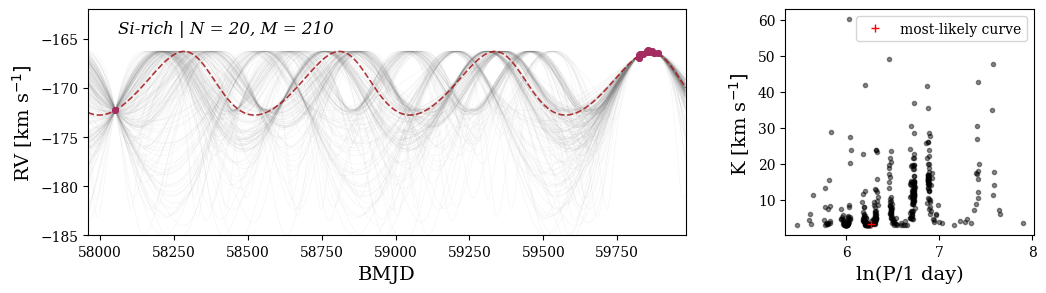

In [23]:
fig = plt.figure(figsize=(22,10))

gs = fig.add_gridspec(nrows=3, ncols=3, left=0.05, right=0.48, wspace=0.4)
f_ax1 = fig.add_subplot(gs[-1, :-1])
f_ax2 = fig.add_subplot(gs[-1,-1])

_ = tj.plot_rv_curves(Filtrado,data=data,plot_kwargs=dict(color="tab:grey"),data_plot_kwargs=dict(color="#A52C60"),relative_to_t_ref=False,ax=f_ax1)
#_ = tj.plot_rv_curves(Filtrado.median_period(),data=data,plot_kwargs=dict(linestyle = "--", linewidth = 1.2,color="#a4161a"),data_plot_kwargs=dict(color="#A52C60"),relative_to_t_ref=False,ax=f_ax1, add_labels=True)
_ = tj.plot_rv_curves(orbita,data=data,plot_kwargs=dict(linestyle = "--", linewidth = 1.2,color="#a4161a"),data_plot_kwargs=dict(color="#A52C60"),relative_to_t_ref=False,ax=f_ax1, add_labels=True)

f_ax2.scatter(np.log(samples['P'].value), samples['K'].value,marker='.', color='k', alpha=0.45)

#f_ax2.plot(np.log(Filtrado.median_period()["P"].value),Filtrado.median_period()["K"], "+", color = "red", label = 'median_period curve' )
f_ax2.plot(np.log(orbita["P"].value),orbita["K"], "+", color = "red", label = 'most-likely curve' )

f_ax1.set_xlabel("BMJD",fontsize=14)
f_ax1.set_ylabel("RV [km s$^{-1}]$", fontsize=14)

f_ax2.set_xlabel("ln(P/1 day)",fontsize=14)
f_ax2.set_ylabel("K [km s$^{-1}]$ ",fontsize=14)

f_ax1.set_ylim(-185,-162)
f_ax1.text(0.05, 0.95, f'Si-rich | N = {len(t)}, M = {len(Filtrado)}', transform=f_ax1.transAxes, fontsize = 12, verticalalignment='top', horizontalalignment='left', fontstyle = 'italic')
f_ax2.legend(fontsize = 10)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


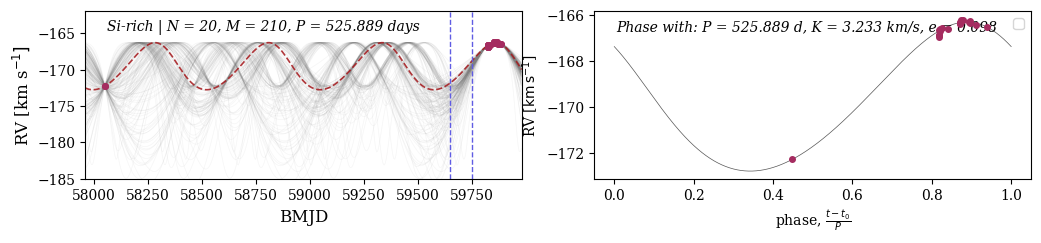

In [67]:
fig = plt.figure(figsize=(22,10))

gs = fig.add_gridspec(nrows=4, ncols=4, left=0.05, right=0.48, wspace=0.4)
f_ax1 = fig.add_subplot(gs[-1, :-2])
f_ax2 = fig.add_subplot(gs[-1,-2:])

_ = tj.plot_rv_curves(Filtrado,data=data,plot_kwargs=dict(color="tab:grey"),data_plot_kwargs=dict(color="#A52C60"),relative_to_t_ref=False,ax=f_ax1)
#_ = tj.plot_rv_curves(Filtrado.median_period(),data=data,plot_kwargs=dict(linestyle = "--", linewidth = 1.2,color="#a4161a"),data_plot_kwargs=dict(color="#A52C60"),relative_to_t_ref=False,ax=f_ax1, add_labels=True)
_ = tj.plot_rv_curves(orbita,data=data,plot_kwargs=dict(linestyle = "--", linewidth = 1.2,color="#a4161a"),data_plot_kwargs=dict(color="#A52C60"),relative_to_t_ref=False,ax=f_ax1, add_labels=True)

#f_ax2.scatter(np.log(samples['P'].value), samples['K'].value,marker='.', color='k', alpha=0.45)
_ = tj.plot_phase_fold(orbita, data=data,ax=f_ax2,remove_trend = False, data_plot_kwargs=dict(color="#A52C60"))


#f_ax2.plot(np.log(Filtrado.median_period()["P"].value),Filtrado.median_period()["K"], "+", color = "red", label = 'median_period curve' )
# f_ax2.plot(np.log(orbita["P"].value),orbita["K"], "+", color = "red", label = 'most-likely curve' )
f_ax1.axvline(59650, color = "#605ce3", linewidth = 1, linestyle = "dashed");
f_ax1.axvline(59750, color = "#605ce3", linewidth = 1, linestyle = "dashed");

f_ax1.set_xlabel("BMJD",fontsize=12)
f_ax1.set_ylabel("RV [km s$^{-1}]$", fontsize=12)

# f_ax2.set_xlabel("Phase, \frac{t-t_0}{P}",fontsize=14)
# f_ax2.set_ylabel("RV [km s$^{-1}]$ ",fontsize=14)

f_ax1.set_ylim(-185,-162)
f_ax1.text(0.05, 0.95, f'Si-rich | N = {len(t)}, M = {len(Filtrado)}, P = {round(orbita["P"][0].value,3)} days', transform=f_ax1.transAxes, fontsize = 10, verticalalignment='top', horizontalalignment='left', fontstyle = 'italic')
f_ax2.text(0.05, 0.95,f"Phase with: P = {round(float(orbita['P'].value),3)} d, K = {round(float(orbita['K'].value),3)} km/s, e = {round(float(orbita['e'].value),3)}", transform=f_ax2.transAxes, fontsize = 10, verticalalignment='top', horizontalalignment='left', fontstyle = 'italic')
f_ax2.legend(fontsize = 10)
plt.show()

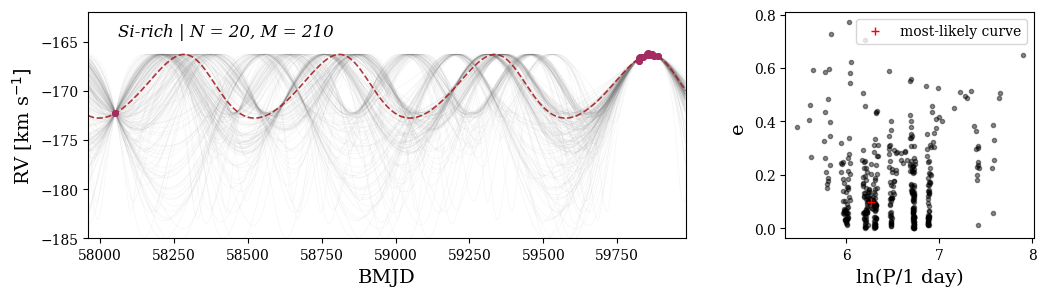

In [37]:
fig = plt.figure(figsize=(22,10))

gs = fig.add_gridspec(nrows=3, ncols=3, left=0.05, right=0.48, wspace=0.4)
f_ax1 = fig.add_subplot(gs[-1, :-1])
f_ax2 = fig.add_subplot(gs[-1,-1])

_ = tj.plot_rv_curves(Filtrado,data=data,plot_kwargs=dict(color="tab:grey"),data_plot_kwargs=dict(color="#A52C60"),relative_to_t_ref=False,ax=f_ax1)
#_ = tj.plot_rv_curves(Filtrado.median_period(),data=data,plot_kwargs=dict(linestyle = "--", linewidth = 1.2,color="#a4161a"),data_plot_kwargs=dict(color="#A52C60"),relative_to_t_ref=False,ax=f_ax1, add_labels=True)
_ = tj.plot_rv_curves(orbita,data=data,plot_kwargs=dict(linestyle = "--", linewidth = 1.2,color="#a4161a"),data_plot_kwargs=dict(color="#A52C60"),relative_to_t_ref=False,ax=f_ax1, add_labels=True)

f_ax2.scatter(np.log(samples['P'].value), samples['e'].value,marker='.', color='k', alpha=0.45)

#f_ax2.plot(np.log(Filtrado.median_period()["P"].value),Filtrado.median_period()["e"], "+", color = "red" ,label = 'median_period curve'  )
f_ax2.plot(np.log(orbita["P"].value),orbita["e"], "+", color = "red", label = 'most-likely curve' )

# axs[0].axvline(59500+Filtrados_all[0].median_period()["P"].value, color = "b", linewidth = 1, linestyle = "dashed");

f_ax1.set_xlabel("BMJD",fontsize=14)
f_ax1.set_ylabel("RV [km s$^{-1}]$", fontsize=14)

f_ax2.set_xlabel("ln(P/1 day)",fontsize=14)
f_ax2.set_ylabel("e ",fontsize=14)

f_ax1.set_ylim(-185,-162)
f_ax1.text(0.05, 0.95, f'Si-rich | N = {len(t)}, M = {len(Filtrado)}', transform=f_ax1.transAxes, fontsize = 12, verticalalignment='top', horizontalalignment='left', fontstyle = 'italic')
f_ax2.legend(fontsize = 10)
plt.show()

In [31]:
def BMJD_to_hms(bmjd):
    # Convertir BMJD a JD (suponiendo que BMJD es similar a MJD)
    jd = bmjd + 2400000.5
    
    # Convertir JD a una fecha estándar usando astropy
    fecha = Time(jd, format='jd').to_value('iso', subfmt='date_hms')
    return fecha

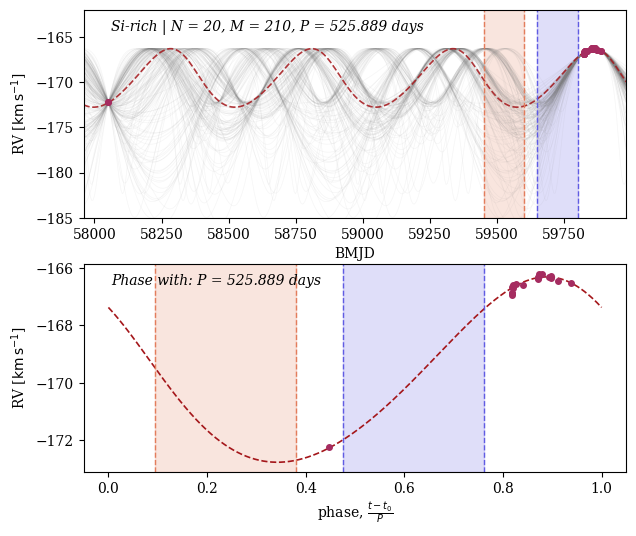

In [189]:
fig, ax = plt.subplots(2, 1, sharex=False, figsize=(7, 6), gridspec_kw={"height_ratios": (1.8,1.8), 'hspace': 0.22})

_ = tj.plot_rv_curves(Filtrado,data=data,plot_kwargs=dict(color="tab:grey"),data_plot_kwargs=dict(color="#A52C60"),relative_to_t_ref=False,ax=ax[0])
_ = tj.plot_rv_curves(orbita,data=data,plot_kwargs=dict(linestyle = "--", linewidth = 1.2,color="#a4161a"),data_plot_kwargs=dict(color="#A52C60"),relative_to_t_ref=False,ax=ax[0], add_labels=True)

    
_ = tj.plot_phase_fold(orbita, data=data, plot_kwargs=dict(linestyle = "--", linewidth = 1.2,color="#a4161a"),ax=ax[1],remove_trend = False, data_plot_kwargs=dict(color="#A52C60"))
# _ = tj.plot_phase_fold(orbita, data, ax=ax[2], residual=True, data_plot_kwargs=dict(color="#A52C60"))
ax[0].set_ylim(-185,-162)
ax[0].text(0.05, 0.95, f'Si-rich | N = {len(t)}, M = {len(Filtrado)}, P = {round(orbita["P"][0].value,3)} days', transform=ax[0].transAxes, fontsize = 10, verticalalignment='top', horizontalalignment='left', fontstyle = 'italic')
ax[1].text(0.05, 0.95,f"Phase with: P = {round(float(orbita['P'].value),3)} days", transform=ax[1].transAxes, fontsize = 10, verticalalignment='top', horizontalalignment='left', fontstyle = 'italic')
# ax[2].axhline(0, zorder=-10, color="#73a942", alpha=0.8)
# ax[2].set_ylim(-0.5, 0.5)
fecha1 = 59650
fecha2 = 59800
fecha3 = 59450
fecha4 = 59600
ax[0].axvline(fecha1, color = "#605ce3", linewidth = 1, linestyle = "dashed");
ax[0].axvline(fecha2, color = "#605ce3", linewidth = 1, linestyle = "dashed");
ax[0].axvspan(fecha1, fecha2, color='#605ce3', alpha=0.2)

ax[0].axvline(fecha3, color = "#e37d5c", linewidth = 1, linestyle = "dashed");
ax[0].axvline(fecha4, color = "#e37d5c", linewidth = 1, linestyle = "dashed");
ax[0].axvspan(fecha3, fecha4, color='#e37d5c', alpha=0.2)

x1 = (fecha1-59400)/orbita["P"][0].value
x2 = (fecha2-59400)/orbita["P"][0].value
x3 = (fecha3-59400)/orbita["P"][0].value
x4 = (fecha4-59400)/orbita["P"][0].value
ax[1].axvspan(x1, x2, color='#605ce3', alpha=0.2)
ax[1].axvline(x1, color = "#605ce3", linewidth = 1, linestyle = "dashed");
ax[1].axvline(x2, color = "#605ce3", linewidth = 1, linestyle = "dashed");
ax[1].axvspan(x3, x4, color='#e37d5c', alpha=0.2)
ax[1].axvline(x3, color = "#e37d5c", linewidth = 1, linestyle = "dashed");
ax[1].axvline(x4, color = "#e37d5c", linewidth = 1, linestyle = "dashed");


In [185]:
f_c1 = fecha3+3*orbita["P"].value
print(f"La posible fecha de observación para P = {orbita['P'].value} es: {f_c1} = {BMJD_to_hms(f_c1)}")
f_c2 = fecha4+3*orbita["P"].value
print(f"La posible fecha de observación para P = {orbita['P'].value} es: {f_c1} = {BMJD_to_hms(f_c2)}")
f_c3 = fecha1+2*orbita["P"].value
print(f"La posible fecha de observación para P = {orbita['P'].value} es: {f_c1} = {BMJD_to_hms(f_c3)}")
f_c4 = fecha2+2*orbita["P"].value
print(f"La posible fecha de observación para P = {orbita['P'].value} es: {f_c1} = {BMJD_to_hms(f_c4)}")

La posible fecha de observación para P = [525.88926026] es: [61027.66778078] = ['2025-12-18 16:01:36.260']
La posible fecha de observación para P = [525.88926026] es: [61027.66778078] = ['2026-05-17 16:01:36.260']
La posible fecha de observación para P = [525.88926026] es: [61027.66778078] = ['2025-01-26 18:41:04.173']
La posible fecha de observación para P = [525.88926026] es: [61027.66778078] = ['2025-06-25 18:41:04.173']


#### Función de masa binaria
$$f(M) = \frac{M_2 \sin^3(i)}{(1+q)^2} = \frac{PK_1^3 (1-e^2)^{3/2}}{2\pi G}$$

Con $q = \frac{M_1}{M_2}$

Las **enanas marrones** son objetos subestelares que tienen más masa que los planetas gigantes gaseosos más grandes , pero menos que las estrellas menos masivas de la secuencia principal. Su masa es aproximadamente de $13 - 80$ veces la de Júpiter ( $M_J$ ) 

In [58]:
# En nuestro caso
def Calculo_Masa(P,K,e):
    P = float(P.value)*u.day
    e = float(e)
    K = float(K.to("m/s").value)*u.m/u.s
    
    print("P =",P)
    print("e =",e)
    print("K =",K)
    
    def f(P,e,K):
        G = 6.67430e-11*(u.m)**3*1/u.kg * 1/u.s**2
        f = (P*K**3*(1-e**2)**(3/2))/(2*np.pi*G)
        f = f.cgs
        f = (f/(1.989e+33*u.g)*u.M_sun)
        return f
    
    # Función de masa
    f_value = f(P,e,K)
    
    
    M1 = 0.8*u.M_sun
    sini =  1
    
    # Ejemplo de uso
    def resolver_ecuacion_cubica(a, b, c, d):
        coeficientes = [a, b, c, d]
        raices = np.roots(coeficientes)
        return raices
        
    a = (sini)**3
    b = -f_value.value
    c = -2*M1.value*f_value.value
    d = -M1.value**2*f_value.value
    
    raices = resolver_ecuacion_cubica(a, b, c, d)
    print("Las raíces de la ecuación son:", raices)
    
    M2 = raices[0].real*u.M_sun
    M_jupiter = 1.898e27*u.kg
    print("La masa del objeto en M_Sun, M2 = ",M2)
    print("La masa del objeto en kg, M2 = ",M2.to("kg"))
    print("La masa del objeto en M_J, M2 = ",M2.to("M_jup"))
    print("La masa del objeto en M_E, M2 = ",M2.to("M_earth"))
    return M2

In [60]:
M2 = Calculo_Masa(orbita["P"],orbita["K"],orbita["e"])

P = 525.8892602606559 d
e = 0.09833436798772219
K = 3233.443326603468 m / s
Las raíces de la ecuación son: [ 0.11496169+0.j        -0.05657339+0.0830852j -0.05657339-0.0830852j]
La masa del objeto en M_Sun, M2 =  0.11496168668780601 solMass
La masa del objeto en kg, M2 =  2.285909525621302e+29 kg
La masa del objeto en M_J, M2 =  120.42989848134803 jupiterMass
La masa del objeto en M_E, M2 =  38276.0427406853 earthMass


In [61]:
M2

<Quantity 0.11496169 solMass>

In [62]:
def f(P,e,K):
        G = 6.67430e-11*(u.m)**3*1/u.kg * 1/u.s**2
        f = (P*K**3*(1-e**2)**(3/2))/(2*np.pi*G)
        f = f.cgs
        f = (f/(1.989e+33*u.g)*u.M_sun)
        return f
M1 = 0.8*u.M_sun
sini =  1

In [63]:
def resolver_ecuacion_cubica(a, b, c, d):
        coeficientes = [a, b, c, d]
        raices = np.roots(coeficientes)
        return raices

In [64]:
P_all = Filtrado["P"]
e_all = Filtrado["e"]
K_all = Filtrado["K"].to(u.m/u.s)

# Función de masa
f_value_all = f(P_all,e_all,K_all)
f_value_all


<Quantity [0.00986447, 0.00185691, 0.00294969, 0.00251083, 0.00276331,
           0.01655577, 0.01257494, 0.00254291, 0.00366889, 0.00407133,
           0.00434953, 0.0032573 , 0.00135786, 0.00315886, 0.00289148,
           0.00587051, 0.0280692 , 0.00160283, 0.00159664, 0.00118278,
           0.0013656 , 0.00148912, 0.0074023 , 0.00134146, 0.01740005,
           0.00106683, 0.00360316, 0.00567685, 0.00601459, 0.00140165,
           0.01264675, 0.00209205, 0.00616135, 0.00718071, 0.00113569,
           0.00548706, 0.00114104, 0.00498381, 0.00239076, 0.00223691,
           0.00547407, 0.0036806 , 0.00686115, 0.0012999 , 0.00122417,
           0.00774395, 0.00275037, 0.00131212, 0.0538263 , 0.00603552,
           0.00477894, 0.00227191, 0.00747557, 0.0039638 , 0.01894611,
           0.00294145, 0.00190969, 0.00175095, 0.00143633, 0.00142724,
           0.00618237, 0.00257781, 0.00253488, 0.00280109, 0.00383914,
           0.01610481, 0.01415469, 0.00144425, 0.00147339, 0.00148687,
      

In [65]:
a_all = [(sini)**3]*len(f_value_all.value)
b_all = -f_value_all.value
c_all = -2*M1.value*f_value_all.value
d_all = -M1.value**2*f_value_all.value

raices_all = []
M2_all = []
for i in np.arange(len(f_value_all)):
    raices_all = (resolver_ecuacion_cubica(a_all[i], b_all[i], c_all[i], d_all[i]))
    M2_all.append(((raices_all[0].real*u.M_sun).value))

In [66]:
P_all_full = samples["P"]
e_all_full = samples["e"]
K_all_full = samples["K"].to(u.m/u.s)

# Función de masa
f_value_all_full = f(P_all_full,e_all_full,K_all_full)
f_value_all_full

<Quantity [6.72331744e-01, 5.59232148e-02, 9.86447335e-03, 2.43113466e+00,
           1.85690650e-03, 1.93112421e-02, 2.94968665e-03, 4.79517969e-01,
           1.47224543e-01, 2.51082600e-03, 9.82776497e-03, 2.76330785e-03,
           1.33900178e+00, 1.65557678e-02, 1.25749424e-02, 2.74127347e-01,
           2.54290861e-03, 3.66888753e-03, 4.07132676e-03, 4.34952730e-03,
           8.10980345e-02, 6.61362110e-01, 3.25729508e-03, 1.15609425e-01,
           4.92661189e-01, 1.35786298e-03, 3.15886325e-03, 2.89148286e-03,
           5.90286864e-03, 5.87050968e-03, 4.74954803e-01, 8.53908149e-02,
           8.00281071e-01, 1.88803678e-01, 2.80691981e-02, 1.60283427e-03,
           2.20906402e-01, 1.68129522e-01, 1.59663769e-03, 1.18277872e-03,
           1.36560311e-03, 1.48912334e-03, 3.88076448e-01, 3.02350795e-01,
           7.40229536e-03, 4.31369591e-02, 1.34146128e-03, 1.74000516e-02,
           2.87796457e-01, 1.06682682e-03, 4.42266442e-03, 3.60316241e-03,
           3.13568445e-01

In [67]:
a_all_full = [(sini)**3]*len(f_value_all_full.value)
b_all_full = -f_value_all_full.value
c_all_full = -2*M1.value*f_value_all_full.value
d_all_full = -M1.value**2*f_value_all_full.value

raices_all_full = []
M2_all_full = []
for i in np.arange(len(f_value_all_full)):
    raices_all_full = (resolver_ecuacion_cubica(a_all_full[i], b_all_full[i], c_all_full[i], d_all_full[i]))
    M2_all_full.append(((raices_all_full[0].real*u.M_sun).value))

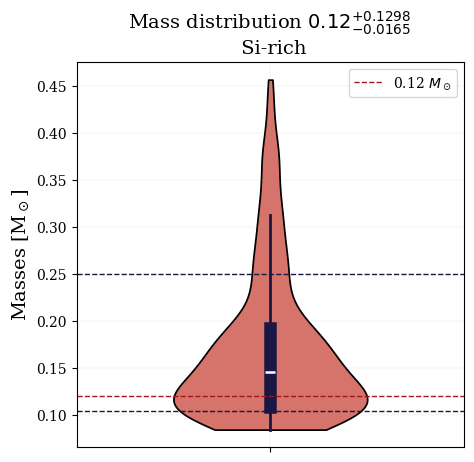

In [79]:
plt.figure(figsize=(5,5))


sns.violinplot(y = abs(np.array(M2_all)),inner_kws=dict(box_width=9, whis_width=2, color="#191743"),
               color = "#e3685c",saturation=0.8, fill=True, inner='box', split=False, width=0.5,
               dodge='auto', gap=0,density_norm='area',common_norm=False, bw_adjust=0.85,
              linecolor='k', cut=0, gridsize=250, native_scale=False)

# Calcula la densidad de la distribución
density = gaussian_kde(M2_all)

# Encuentra el rango de valores en el eje y
y_values = np.linspace(min(M2_all), max(M2_all), 1000)

# Evalúa la densidad en el rango de valores en el eje y
density_values = density(y_values)

# Encuentra el índice del máximo valor de densidad
peak_index = np.argmax(density_values)

# Encuentra el valor en el eje y correspondiente al pico
peak_value = y_values[peak_index]
percentile_16_mass = np.percentile(np.array(M2_all), 16)
percentile_84_mass = np.percentile(np.array(M2_all), 84)

# Calcular el error estimado (asimétrico)
error_lower_mass = (peak_value - percentile_16_mass)
error_upper_mass = (percentile_84_mass - peak_value)

#print("El pico más alto de la distribución está en:", peak_value)

#plt.axhline(y=M2.value, color='#D0D3D4', linestyle='--',linewidth = 1, label = f'$M_2$ = { round(float(M2.value),3)} $M_\odot$')
plt.axhline(y=peak_value, color='#a4161a', linestyle='--',linewidth = 1, label = f'{ round(peak_value,4)} $M_\odot$')
plt.axhline(peak_value-abs(error_lower_mass), color='#191743', linestyle='dashed', linewidth=1)
plt.axhline(peak_value+abs(error_upper_mass), color='#191743', linestyle='dashed', linewidth=1)

plt.ylabel("Masses [M$_\odot$]", fontsize = 14)
plt.title("Mass distribution"+f" ${round(peak_value,4)}^{{+{round(abs(error_upper_mass),4)}}}_{{-{round(abs(error_lower_mass),4)}}}$ \n Si-rich", fontsize = 14)
plt.legend()
plt.grid(linestyle='-', linewidth=0.1)
plt.show()

In [80]:
print("Cálculamos la Masa con el pick más alto de la distribución de Periodos y con el pick más alto de la distribución de Masas")
print(f"La diferencia entre estos valores es: {abs(M2.value-peak_value)/abs(peak_value)*100} %")

Cálculamos la Masa con el pick más alto de la distribución de Periodos y con el pick más alto de la distribución de Masas
La diferencia entre estos valores es: 4.165754886014321 %


In [81]:
# Nombre del archivo
import csv
nombre_archivo = 'Mass_dist_Sirich.csv'

# Escribir la lista en un archivo .csv
with open(nombre_archivo, mode='w', newline='') as archivo:
    escritor_csv = csv.writer(archivo)
    for elemento in M2_all:
        escritor_csv.writerow([elemento])

print(f"Lista guardada en {nombre_archivo}")

Lista guardada en Mass_dist_Sirich.csv


In [82]:
Mc = peak_value*u.M_sun.to("M_jup")
Mme = error_upper_mass*u.M_sun.to("M_jup")
Mma = error_lower_mass*u.M_sun.to("M_jup")

print(f"Mass distribution {round(Mc,4)}^{{+{round(abs(Mme),4)}}}_{{-{round(abs(Mma),4)}}} \n")

Mass distribution 125.6648^{+135.9922}_{-17.253} 



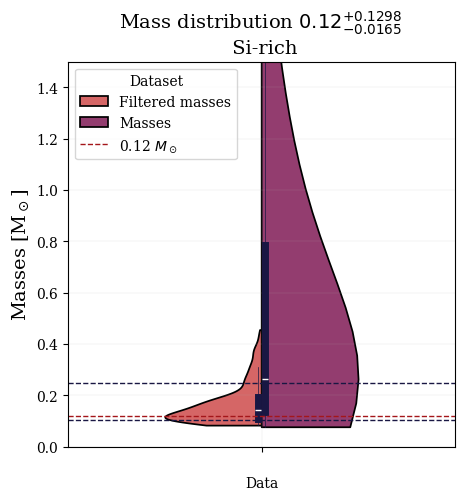

In [83]:
# Crear un DataFrame con las dos listas de datos
plt.figure(figsize=(5,5))
plt.title("Mass distribution", fontsize = 16)

data = pd.DataFrame({
    'Value': M2_all + M2_all_full,
    'Dataset': ['Filtered masses'] * len(M2_all) + ['Masses'] * len(M2_all_full),
    'Data': ['  '] * len(M2_all) + ['  '] * len(M2_all_full)
})

# Crear el diagrama de violín con split=True usando la columna 'Category' para dividir los lados
sns.violinplot(x='Data', y='Value', hue='Dataset', data=data,inner_kws=dict(box_width=5, whis_width=0.5, color="#191743"),
               saturation=0.85, fill=True, inner='box', split=True, width=0.5,
               dodge='auto', gap=0,density_norm='area',common_norm=False, bw_adjust=0.85,
              linecolor='k', cut=0, gridsize=250, native_scale=False, palette = "flare")
plt.axhline(y=peak_value, color='#a4161a', linestyle='--',linewidth = 1, label = f'{ round(peak_value,4)} $M_\odot$')
plt.axhline(peak_value-abs(error_lower_mass), color='#191743', linestyle='dashed', linewidth=1)
plt.axhline(peak_value+abs(error_upper_mass), color='#191743', linestyle='dashed', linewidth=1)

# Ajustar el gráfico para que se vea mejor
plt.ylim(0,1.5)
plt.legend(loc='upper left',title='Dataset')
plt.ylabel("Masses [M$_\odot$]", fontsize = 14)
plt.title("Mass distribution"+f" ${round(peak_value,4)}^{{+{round(abs(error_upper_mass),4)}}}_{{-{round(abs(error_lower_mass),4)}}}$ \n Si-rich", fontsize = 14)
plt.grid(linestyle='-', linewidth=0.1)
# Mostrar el gráfico
plt.show()

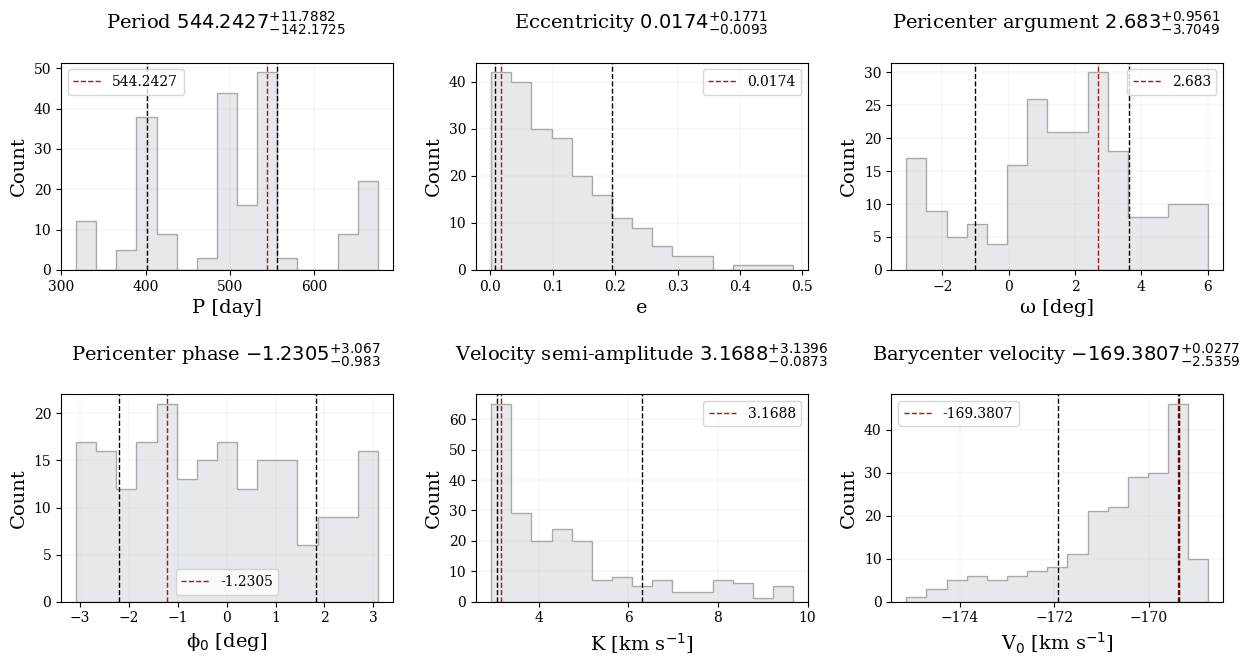

In [84]:
variables = ["P", "e", "omega", "M0", "K", "v0"]
xlabel = ["P [day]", "e", "ω [deg]", "ϕ$_0$ [deg]", "K [km s$^{-1}$]","V$_0$ [km s$^{-1}$]"]
title = ["Period","Eccentricity", "Pericenter argument", "Pericenter phase", "Velocity semi-amplitude", "Barycenter velocity"]
picos = []


fig = plt.figure(figsize=(15,7))

gs = fig.add_gridspec(2, 3, hspace=0.6, wspace=0.25)
(ax1,ax2,ax3), (ax4,ax5,ax6) = gs.subplots(sharey = False, sharex = False)

for ax,i in zip(fig.get_axes(),np.arange(len(variables))):
    ax.set_ylabel("Count", fontsize = 14)
    ax.set_xlabel(xlabel[i], fontsize = 14)
    conteos, bins, _  =  ax.hist(Filtrado[variables[i]], bins = "sqrt", histtype='stepfilled', density = False ,alpha=0.3, align = 'mid', color = '#adb5bd', ec="k")
    # indice_maximo = np.argmax(conteos)
    # # Obtener el valor del pico más alto
    # pico_mas_alto = bins[indice_maximo]
    # picos.append(pico_mas_alto)
    # Calcular percentiles
    # Calcular el histograma y encontrar el pico (máximo de densidad)
    hist, bin_edges = np.histogram(Filtrado[variables[i]].value, bins="sqrt", density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    peak_index = np.argmax(hist)
    peak_value = bin_centers[peak_index]

    percentile_16 = np.percentile(Filtrado[variables[i]].value, 16)
    percentile_84 = np.percentile(Filtrado[variables[i]].value, 84)
    
    # Calcular el error estimado (asimétrico)
    error_lower = (peak_value - percentile_16)
    error_upper = (percentile_84 - peak_value)
    
    ax.set_title(title[i]+f" ${round(peak_value,4)}^{{+{round(abs(error_upper),4)}}}_{{-{round(abs(error_lower),4)}}}$ \n", fontsize = 14)

    # Agregar una línea vertical en el pico más alto
    #ax.axvline(x=pico_mas_alto, color='#a4161a', linestyle='--', linewidth = 1, label = f"{round(pico_mas_alto,2)}")
    ax.axvline(peak_value, color='#a4161a', linestyle='dashed', linewidth=1,label = f"{round(peak_value,4)}")
    ax.axvline(peak_value-abs(error_lower), color='k', linestyle='dashed', linewidth=1)
    ax.axvline(peak_value+abs(error_upper), color='k', linestyle='dashed', linewidth=1)
    ax.grid(linestyle='-', linewidth=0.1)
    ax.legend()

### Estimación de la masa

In [134]:
B = 12.360 
V = 11.400
B_V = B-V
B_V

0.9599999999999991

#### Magnitud absoluta:

$$M = m - 5(log_{10}(d_{pc})-1)$$

In [135]:
m_V = V
d = np.mean([1293.810,1406.272,1307.8734,1138.96]) # Distancias encontradas en Simbad en pc
M=m_V-5*(np.log10(d)-1)
M

0.8525648076515715

#### Luminosidad

$$M = M_{\odot} - 2.5 \log_{10}\left(\frac{L}{L_{\odot}}\right)$$

$$L = 10^{-\frac{M-M_\odot}{2.5}}L_{\odot}$$

In [136]:
L=10**(-(M-4.83)/2.5)
L

38.9918711713353

In [137]:
masa = L**(1/3)
masa

3.3909758148752305